In [77]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

import seaborn

seaborn.set()
seaborn.set_style("ticks")
seaborn.set_context("poster")
from matplotlib import pyplot

In [78]:
def print_perturbation(title, data, marker_styles, curve_colors, curve_styles, 
                       curve_labels, yticks, xtitle, leg_title, rand_base, leg_loc, leg_flag, name):
    fig, ax = plt.subplots(figsize=(4, 3))
    plt.title(title , fontsize=25)
    plt.xlabel(xtitle, fontsize=25)
    plt.ylabel('% Unchanged Labels', fontsize=25)
    plt.xlim((0, 1))
    plt.ylim((-1, np.max(yticks)))
    plt.grid(True, which='both')
    plt.xticks(levels, level_labels)
    plt.yticks(yticks)

    for curve_idx in range(np.shape(data)[0]):
        non_0_idx = (data[curve_idx,:,0] != 0)
        plt.errorbar(levels[non_0_idx], data[curve_idx,non_0_idx,0], yerr=data[curve_idx,non_0_idx,1].T,
                 marker=marker_styles[curve_idx], markersize=7, color=curve_colors[curve_idx],
                 linestyle=curve_styles[curve_idx], linewidth=3)
        

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    if leg_flag:
        leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=12, title=leg_title)
        leg.get_title().set_fontsize('12')
    plt.rc('xtick',labelsize=8)

    plt.show()
    fig.savefig(name+".pdf",format='pdf', bbox_inches='tight',dpi=1000)

In [79]:
sys.path.append('../')
import experiments

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
curves = 5
curve_labels = ['1/4x', '1/2x', '1x', '2x','4x']
cm = seaborn.light_palette("slateblue", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=curves)]
curve_styles = ['-', '-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']
yticks = [0, 20, 40, 60, 80, 100]

range_len = 7
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
noise_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]
crosses = 3

rand_ablation_results = np.zeros((curves, range_len, 2))
noise_results = np.zeros((curves, range_len, 2))
targeted_ablation_results = np.zeros((curves, range_len, 2))
rand_ablation_results_test = np.zeros((curves, range_len, 2))
noise_results_test = np.zeros((curves, range_len, 2))
targeted_ablation_results_test = np.zeros((curves, range_len, 2))
# all are indexed [curve][perturbation_level][avg/lowererr/uppererr]
# note that this will only be for the TEST set

included_nets = [62, 63, 64, 65, 66]

for ID in range(2,32):

    #print('Processing ID:', ID)
    opt = experiments.opt[ID]

    if not opt.init_type in [0]:
        continue
            
    print(opt.dnn.neuron_multiplier[0])
    curve_idx = 0  # unregularized
    if opt.dnn.neuron_multiplier[0] == 0.25:
        curve_idx = 0
    elif opt.dnn.neuron_multiplier[0] == 0.5:
        curve_idx = 1
    elif opt.dnn.neuron_multiplier[0] == 1:
        curve_idx = 2
    elif opt.dnn.neuron_multiplier[0] == 2:
        curve_idx = 3
    elif opt.dnn.neuron_multiplier[0] == 4:
        curve_idx = 4

    csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
    df = pd.read_csv(csv_file)

    rand_ablation = np.zeros((crosses, range_len))
    noise = np.zeros((crosses, range_len))
    targeted_ablation = np.zeros((crosses, range_len))
    rand_ablation_test = np.zeros((crosses, range_len))
    noise_test = np.zeros((crosses, range_len))
    targeted_ablation_test = np.zeros((crosses, range_len))

    for cross in range(crosses):
        for amount in range(range_len):
            rand_ablation[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'train'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            noise[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Noise'] \
                [df['perturbation_amount'] == noise_range[amount]] \
                ['performance'].iloc[0]
            targeted_ablation[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'train'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout Selected'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            rand_ablation_test[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            noise_test[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'test'] \
                [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Noise'] \
                [df['perturbation_amount'] == noise_range[amount]] \
                ['performance'].iloc[0]
            targeted_ablation_test[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout Selected'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]

    rand_ablation_results[curve_idx, :, 0] = np.mean(rand_ablation, axis=0)
    noise_results[curve_idx, :, 0] = np.mean(noise, axis=0)
    targeted_ablation_results[curve_idx, :, 0] = np.mean(targeted_ablation, axis=0)
    
    rand_ablation_results_test[curve_idx, :, 0] = np.mean(rand_ablation_test, axis=0)
    noise_results_test[curve_idx, :, 0] = np.mean(noise_test, axis=0)
    targeted_ablation_results_test[curve_idx, :, 0] = np.mean(targeted_ablation_test, axis=0)
    
    rand_ablation_results[curve_idx, :, 1] = np.std(rand_ablation, axis=0)
    noise_results[curve_idx, :, 1] = np.std(noise, axis=0)
    targeted_ablation_results[curve_idx, :, 1] = np.std(targeted_ablation, axis=0)
    
    rand_ablation_results_test[curve_idx, :, 1] = np.std(rand_ablation_test, axis=0)
    noise_results_test[curve_idx, :, 1] = np.std(noise_test, axis=0)
    targeted_ablation_results_test[curve_idx, :, 1] = np.std(targeted_ablation_test, axis=0)
    
rand_ablation_results *= 100
noise_results *= 100
targeted_ablation_results *= 100
rand_ablation_results_test *= 100
noise_results_test *= 100
targeted_ablation_results_test *= 100





0.25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

0.5
1.0
2.0
4.0


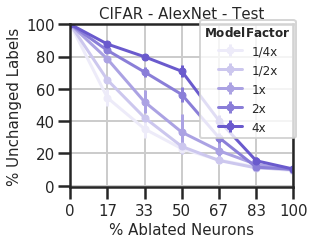

' \nprint_perturbation(r\'CIFAR-10 - Unchanged Labels w/ Noise: Train Set\', noise_results, marker_styles, \n               curve_colors, curve_styles, curve_labels, yticks, r\'$\\sigma$ (noise) / $\\sigma$ (activation)\', r"$\x08f{Regularizer}$", 10)\n\nprint_perturbation(r\'CIFAR-10 - Unchanged Labels w/ Random Ablation: Test Set\', rand_ablation_results_test, marker_styles, \n               curve_colors, curve_styles, curve_labels, yticks, r\'% Ablated Neurons\', r"$\x08f{Regularizer}$", 10)\n\nprint_perturbation(r\'CIFAR-10 - Unchanged Labels w/ Noise: Test Set\', noise_results_test, marker_styles, \n               curve_colors, curve_styles, curve_labels, yticks, r\'$\\sigma$ (noise) / $\\sigma$ (activation)\', r"$\x08f{Regularizer}$", 10)\n'

In [80]:
leg_loc = (0.58, 0.30)  
print_perturbation(r'CIFAR - AlexNet - Test', rand_ablation_results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r'% Ablated Neurons', r"$\bf{Model} \bf{Factor}$", 
                   10,
                   leg_loc, True,
                 "rob_cifar")
''' 
print_perturbation(r'CIFAR-10 - Unchanged Labels w/ Noise: Train Set', noise_results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r'$\sigma$ (noise) / $\sigma$ (activation)', r"$\bf{Regularizer}$", 10)

print_perturbation(r'CIFAR-10 - Unchanged Labels w/ Random Ablation: Test Set', rand_ablation_results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r'% Ablated Neurons', r"$\bf{Regularizer}$", 10)

print_perturbation(r'CIFAR-10 - Unchanged Labels w/ Noise: Test Set', noise_results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r'$\sigma$ (noise) / $\sigma$ (activation)', r"$\bf{Regularizer}$", 10)
'''


In [81]:
sys.path.append('../')
import experiments

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
curves = 5
curve_labels = ['1/4x', '1/2x', '1x', '2x','4x']
cm = seaborn.light_palette("orange", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=curves)]
curve_styles = ['-', '-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']
yticks = [0, 20, 40, 60, 80, 100]

range_len = 7
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
noise_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]
crosses = 3

rand_ablation_results = np.zeros((curves, range_len, 2))
noise_results = np.zeros((curves, range_len, 2))
targeted_ablation_results = np.zeros((curves, range_len, 2))
rand_ablation_results_test = np.zeros((curves, range_len, 2))
noise_results_test = np.zeros((curves, range_len, 2))
targeted_ablation_results_test = np.zeros((curves, range_len, 2))
# all are indexed [curve][perturbation_level][avg/lowererr/uppererr]
# note that this will only be for the TEST set

factors = [1, 2, 4, 8, 16]

for ID in range(343, 542):

    #print('Processing ID:', ID)
    opt = experiments.opt[ID]

    #print('Processing ID:', ID)
    opt = experiments.opt[ID]

    if opt.dataset.dataset_name == "rand10":
        if opt.dnn.name == 'MLP1_linear':
            continue
    else:
            continue

    if not opt.hyper.init_factor == 1e5:
        continue

    #curve_idx = np.where(np.array(opt.hyper.learning_rate) == lr)[0][0]    
    curve_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   

    csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
    df = pd.read_csv(csv_file)

    rand_ablation = np.zeros((crosses, range_len))
    noise = np.zeros((crosses, range_len))
    targeted_ablation = np.zeros((crosses, range_len))
    rand_ablation_test = np.zeros((crosses, range_len))
    noise_test = np.zeros((crosses, range_len))
    targeted_ablation_test = np.zeros((crosses, range_len))

    for cross in range(crosses):
        for amount in range(range_len):
            rand_ablation[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'train'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            noise[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Noise'] \
                [df['perturbation_amount'] == noise_range[amount]] \
                ['performance'].iloc[0]
            targeted_ablation[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'train'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout Selected'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            rand_ablation_test[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            noise_test[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'test'] \
                [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Noise'] \
                [df['perturbation_amount'] == noise_range[amount]] \
                ['performance'].iloc[0]
            targeted_ablation_test[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout Selected'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]

    rand_ablation_results[curve_idx, :, 0] = np.mean(rand_ablation, axis=0)
    noise_results[curve_idx, :, 0] = np.mean(noise, axis=0)
    targeted_ablation_results[curve_idx, :, 0] = np.mean(targeted_ablation, axis=0)
    
    rand_ablation_results_test[curve_idx, :, 0] = np.mean(rand_ablation_test, axis=0)
    noise_results_test[curve_idx, :, 0] = np.mean(noise_test, axis=0)
    targeted_ablation_results_test[curve_idx, :, 0] = np.mean(targeted_ablation_test, axis=0)
    
    rand_ablation_results[curve_idx, :, 1] = np.std(rand_ablation, axis=0)
    noise_results[curve_idx, :, 1] = np.std(noise, axis=0)
    targeted_ablation_results[curve_idx, :, 1] = np.std(targeted_ablation, axis=0)
    
    rand_ablation_results_test[curve_idx, :, 1] = np.std(rand_ablation_test, axis=0)
    noise_results_test[curve_idx, :, 1] = np.std(noise_test, axis=0)
    targeted_ablation_results_test[curve_idx, :, 1] = np.std(targeted_ablation_test, axis=0)
    
rand_ablation_results *= 100
noise_results *= 100
targeted_ablation_results *= 100
rand_ablation_results_test *= 100
noise_results_test *= 100
targeted_ablation_results_test *= 100





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

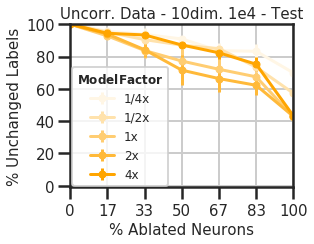

In [82]:
leg_loc = (0.01, 0.01)  
print_perturbation(r'Uncorr. Data - 10dim. 1e4 - Test', rand_ablation_results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r'% Ablated Neurons', r"$\bf{Model} \bf{Factor}$", 
                   50,
                   leg_loc, True,
                 "rob_synth")

In [83]:
#ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments
range_len = 7

opts = experiments.get_experiments('','')
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
curves = 5
curve_labels = ['1/4x',  '1/2x', '1x', '2x','4x']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=curves)]
curve_styles = ['-', '-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']
yticks = [0, 20, 40, 60, 80, 100]
range_len = 7
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
noise_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]

rand_ablation_results = np.zeros((curves, range_len,2))
noise_results = np.zeros((curves, range_len,2))
targeted_ablation_results = np.zeros((curves, range_len,2))



for ID in range(5):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    for amount in range(range_len):
        rand_ablation_results[ID, amount, 0] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        rand_ablation_results[ID, amount, 1] = 0
        
        noise_results[ID, amount, 0] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 3] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        noise_results[ID, amount, 1] = 0
        
        targeted_ablation_results[ID, amount, 0] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        targeted_ablation_results[ID, amount, 1] = 0
        

rand_ablation_results *= 100   
noise_results *= 100   
targeted_ablation_results *= 100                                       


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


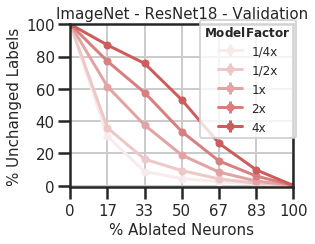

In [84]:
leg_loc = (0.58, 0.30)                                                  
print_perturbation(r'ImageNet - ResNet18 - Validation', rand_ablation_results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r'% Ablated Neurons', r"$\bf{Model} \bf{Factor}$", 0.1,
                   leg_loc, True,
                 "rob_imagenet")
